# Street Network Analysis: Nodes, Paths and Districts
## Working with Shapefiles

In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import geopandas as gpd
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import cityImage as ci

### Important: find EPSG of your case-study area
#### Specify the name of the city for convenience

In [2]:
#initialise path, names, etc.

city_name = 'Boston'
saving_path ='Outputs/'+city_name+'/'
epsg = 26986

## 1. Loading Shapefile

In [3]:
# provide files' directories and loading the data
# the polygon is not strictly necessary. It is needed when clipping the Street Network

#specify your loading paths here 
loading_path_polygon = None
input_path =  'Input/'+city_name+'/boston_4000.shp'

### A note:

To avoid edge effect when computing betweennes centrality values, consider using an area larger than your actual case-study area. 

In [4]:
# Leave "None" for attributes not contained in the dataframe or for attributes of no interest.
dict_columns = {"roadType_field": None,  "direction_field": None, "speed_field": None, "name_field": None}
# if all items are None, don't pass the dictionary in the function

nodes_graph, edges_graph = ci.get_network_fromSHP(input_path, epsg)

## 2 Cleaning and simplyfing the Street Network - gdf

At the end of the previous section two files are obtained: nodes and edges (vertexes, or links). Below, before creating the actual graph, the two datasets are cleaned, simplified and corrected.

Cleaning functions handle:
* Duplicate geometries (nodes, edges).
* Pseudo-nodes.
* Disconnected islands.
* Dead-ends.
* Self-Loops.
* Same u-v nodes edges, with different geometries.

*same_uv_edges* regulates the handling of edges with same pair of u-v nodes but different geometries.
When true keeps a center line between the two segments, unless one of the two segments is longer than the other (>10%). In this case, the longer segment is deleted.

It also:

* Fix topology - breaks lines at intersections with other lines in the streets GeoDataFrame, apart from segments categorised as bridges or tunnels in OSM

In [5]:
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_disconnected_islands = True,
                            same_uv_edges = True, self_loops = True, fix_topology = False)

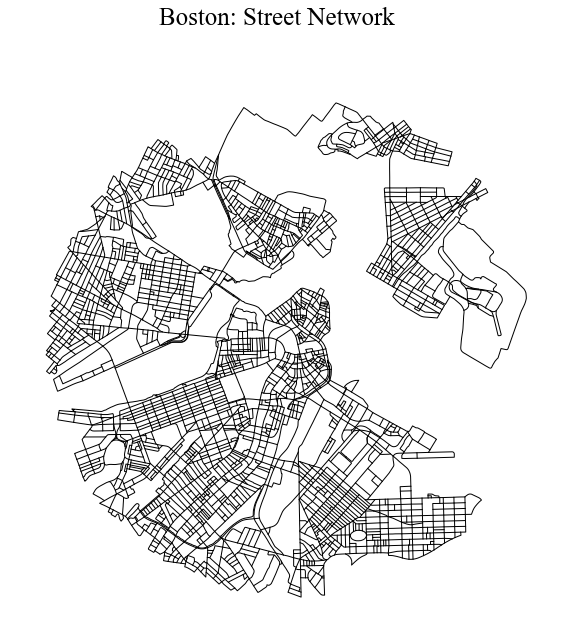

In [6]:
ci.plot_gdf(edges_graph, black_background = False, fig_size = 10, title = city_name+': Street Network', color = 'black')

In [7]:
# Obtaining the graph from the case-study area and computing the centrality measures
graph = ci.graph_fromGDF(nodes_graph, edges_graph)

## 3. - Nodes centrality

On the primal graph representation of the street network, the following centrality measures are computed on nodes, on the basis of road distance:

* Road Distance Shortest Path Betweenness centrality (Bc_Rd).
* Information Centrality (Bc_Rw)
* Straightness centrality (Sc) (see [Crucitti et al. 2006](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.73.036125)).
* Reach centrality (e.g. Rc_400, Rc_600) (readataped from [Sevtsuk & Mekonnen 2012](https://www.sutd.edu.sg/cmsresource/idc/papers/2012_Urban_Network_Analysis_A%20New%20Toolbox_for_ArcGIS.pdf)) - it measures the importance of a node based on the number of services (e.g. commercial activities) reachable by that node (for instance within a buffer).

The first measure (*Bc_Rd*) is here used to identify Lynchian nodes.

In [8]:
"""
"measure" accepts "betweenness_centrality", "information_centrality", "straightness_centrality", "closeness_centrality".
The function returns dictionaries, which are going to be merged in the GDF below.
"""
# betweenness centrality
Bc_Rd = ci.centrality(graph, nodes_graph, measure = "betweenness_centrality", weight = 'length', normalized = False)
# information centrality
Bc_Rw =  ci.centrality(graph, nodes_graph, measure ="information_centrality", weight = 'length', normalized = False)
# straightness centrality
Sc = ci.centrality(graph, nodes_graph, measure = "straightness_centrality", weight = 'length', normalized = False)

#### If using POI from OSM: Choose which of the following amenities you consider relevant as "services" for computing reach centrlality. Check [OSM amenities](https://wiki.openstreetmap.org/wiki/Key:amenity) for details

In [9]:
amenities = ['arts_centre', 'atm', 'bank', 'bar', 'bbq', 'bicycle_rental', 'bicycle_repair_station', 'biergarten', 
             'boat_rental', 'boat_sharing', 'brothel', 'bureau_de_change', 'cafe', 'car_rental', 'car_sharing', 'car_wash', 'casino', 'childcare',
           'cinema', 'clinic', 'college', 'community_centre', 'courthouse', 'crematorium', 'dentist', 'dive_centre', 'doctors', 
           'driving_school', 'embassy', 'fast_food', 'ferry_terminal', 'fire_station', 'food_court', 'fuel', 'gambling', 'gym', 
           'hospital', 'ice_cream', 'internet_cafe', 'kindergarten', 'kitchen', 'language_school', 'library', 'marketplace', 
           'monastery', 'motorcycle_parking', 'music_school', 'nightclub', 'nursing_home', 'pharmacy', 'place_of_worship', 
           'planetarium', 'police', 'post_office', 'prison', 'pub', 'public_building', 'ranger_station', 'restaurant', 'sauna',
           'school', 'shelter', 'shower', 'social_centre', 'social_facility', 'stripclub', 'studio', 'swingerclub', 'theatre', 
           'toilets', 'townhall', 'university', 'veterinary']

In [13]:
# reach centrality pre-computation, in relation to Point of Interests or any other point-geodataframes 
convex_hull_wgs = ci.convex_hull_wgs(edges_graph)
services = ox.geometries.geometries_from_polygon(convex_hull_wgs, tags = {'amenity':True}).to_crs(epsg=epsg)
services = services[services.amenity.isin(amenities)]
services = services[services['geometry'].geom_type == 'Point']

# using a 50 mt buffer
graph = ci.weight_nodes(nodes_graph, services, graph, field_name = 'services',  radius = 50)

# Reach Centrality
Rc400 = ci.reach_centrality(graph, weight = 'length', radius = 400, attribute = 'services') 
Rc600 = ci.reach_centrality(graph, weight = 'length', radius = 600, attribute = 'services')

In [14]:
## Appending the attributes to the geodataframe
dicts = [Bc_Rd, Bc_Rw, Sc, Rc400, Rc600]
columns = ['Bc_Rd', 'Bc_Rw', 'Sc', 'Rc400', 'Rc600']
for n,c in enumerate(dicts): 
    nodes_graph[columns[n]] = nodes_graph.nodeID.map(c)

### 3.1 Nodes' centrality - Visualisation

In [15]:
col = ['Bc_Rd', 'Bc_Rw', 'Sc', 'Rc400', 'Rc600']
titles = ['Betweennes Centrality - Shortest Path', 'Betweennes Centrality - Random Walker', 
         'Straightness Centrality', 'Reach Centrality 400 mt radius', 'Reach Centrality 600 mt radius']

#### Parameters 
* legend: boolean, shows the legend
* color bar: boolean, shows the color bar - attributes:
    * only_min_max (boolean) = if True shows only min and max ticks (when not providing a norma
    * cbar_max_symbol: boolean, if you want to visaulise the symbol ">" next to the highest tick in the color bar (useful when normalizing the data into a certain range, see below).
    * cbar_ticks: integer, nr ticks to visualise
* gdf_base_map, GeoDataFrame - attributes:
    * base_map_zorder = (0,1)
    * base_map_lw, line width if gdf_base_map is a LineString GeoDataFrame
    * base_map_ms, marker size, if gdf_base_map is a Point GeoDataFrame
    * base_map_color
    * base_map_alpha
* axis_frame: boolean, depicts a fram around each axis when True
* classes: intger, e.g. n = 5, if using schemes, unless scheme = 'Lynch_breaks' or scheme = 'User_Defined' (when providing bins)
* norm, list (see https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.colors.Normalize.html)
* cmap
(and other Matplotlib parameters)

#### Grid visualisation

C:\Users\g_filo01\AppData\Local\Continuum\miniconda3\envs\cityImage\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\g_filo01\AppData\Local\Continuum\miniconda3\envs\cityImage\lib\cityImage\plotting.py:592: MatplotlibDeprecationWarning: Saw kwargs ['size', 'fontsize'] which are all aliases for 'fontsize'.  Kept value from 'fontsize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  plt.setp(plt.getp(cax.axes, "yticklabels"), size = 0, color = text_color, fontfamily = 'Times New Roman', fontsize=font_size)


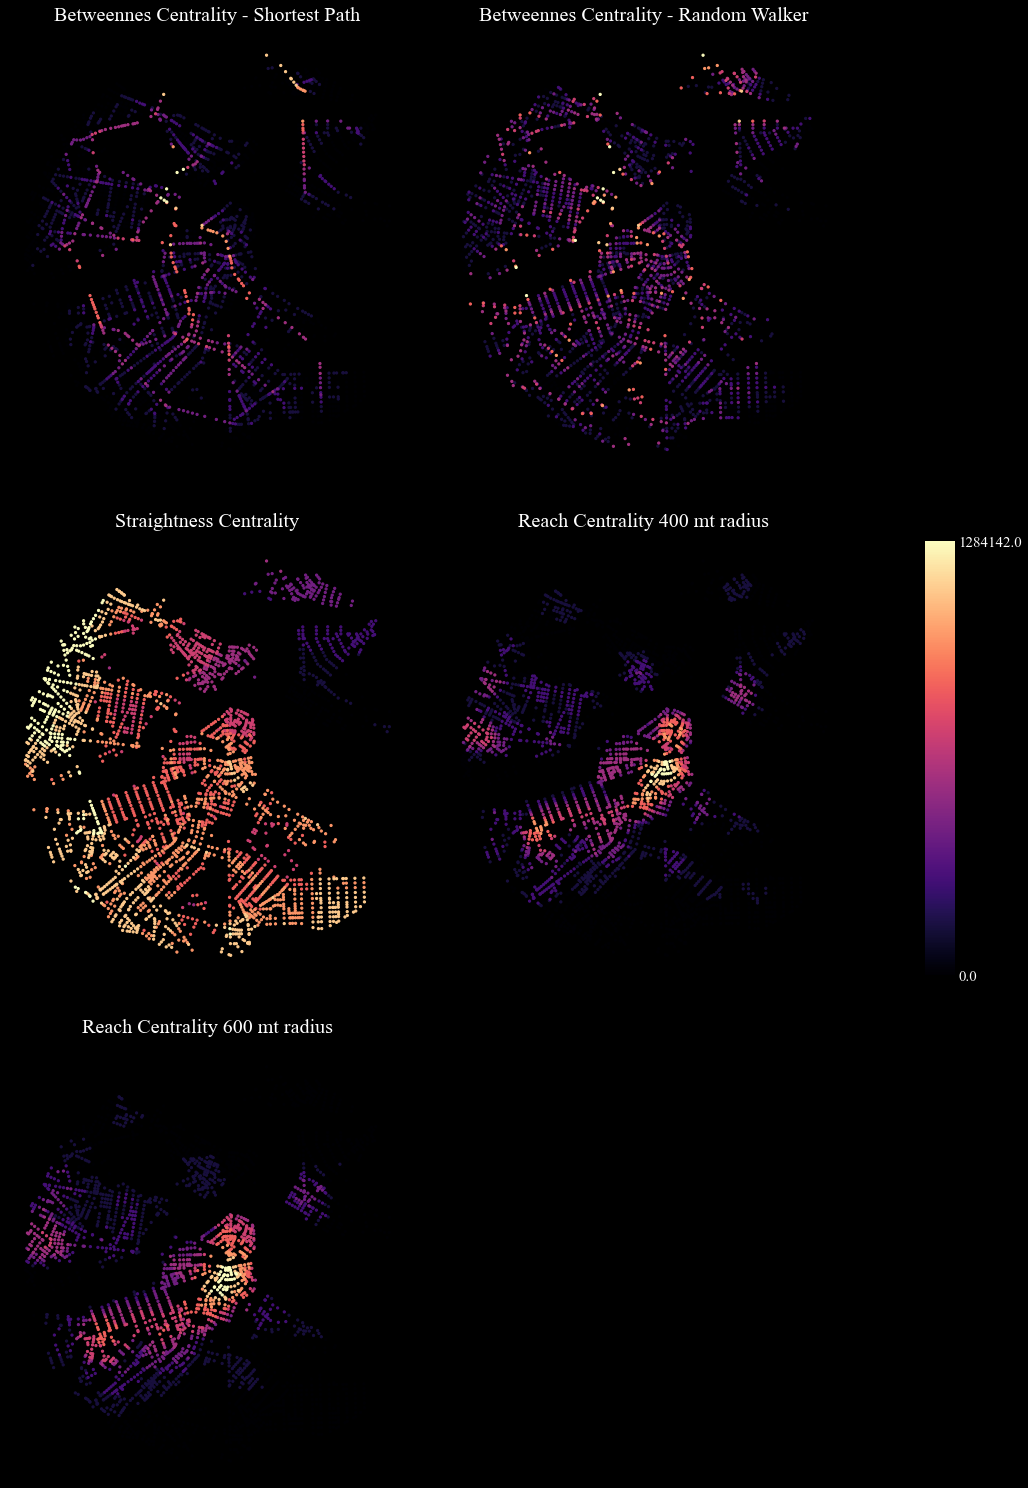

In [16]:
fig = ci.plot_gdf_grid(nodes_graph, titles = titles, columns = col, classes = 10, cmap = 'magma', fig_size = 15, ms = 5,
                   scheme = 'natural_breaks', cbar = True, only_min_max = True)

#### Single figure visualisation with Lynch-like Breaks

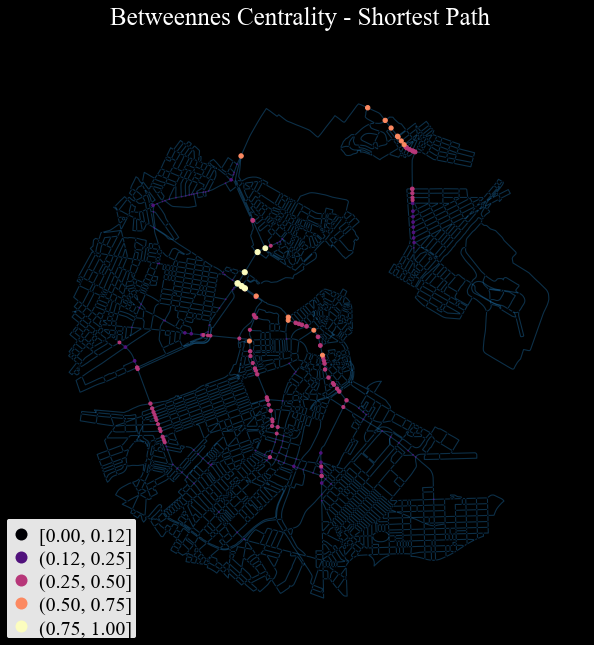

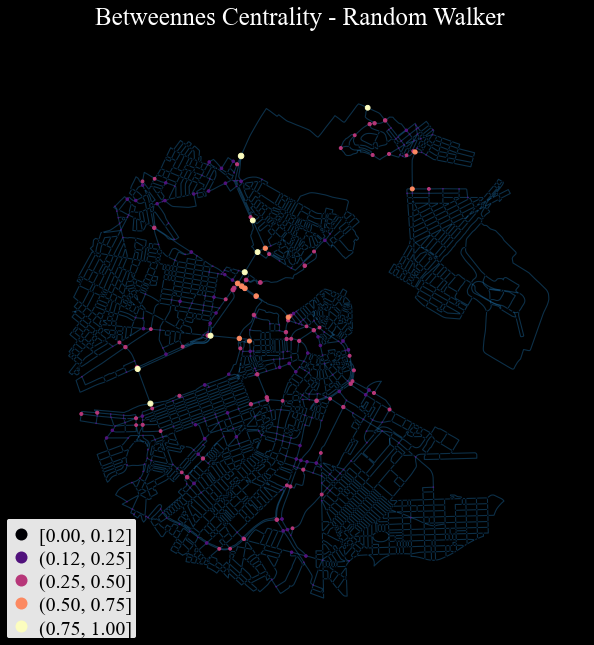

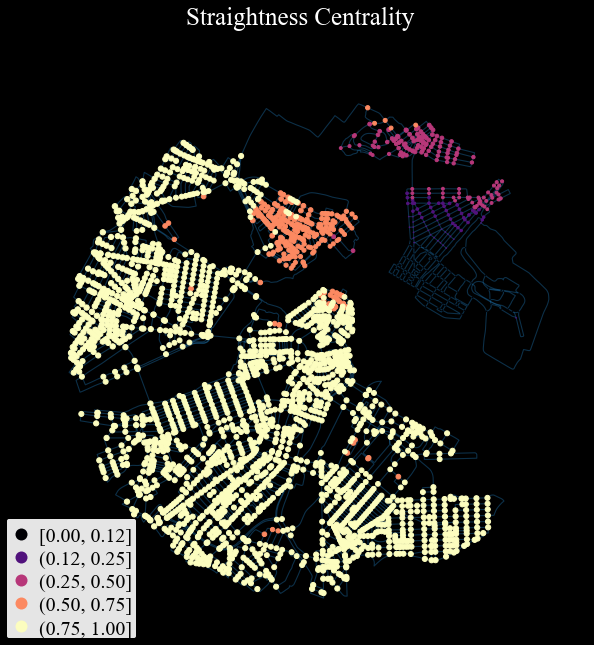

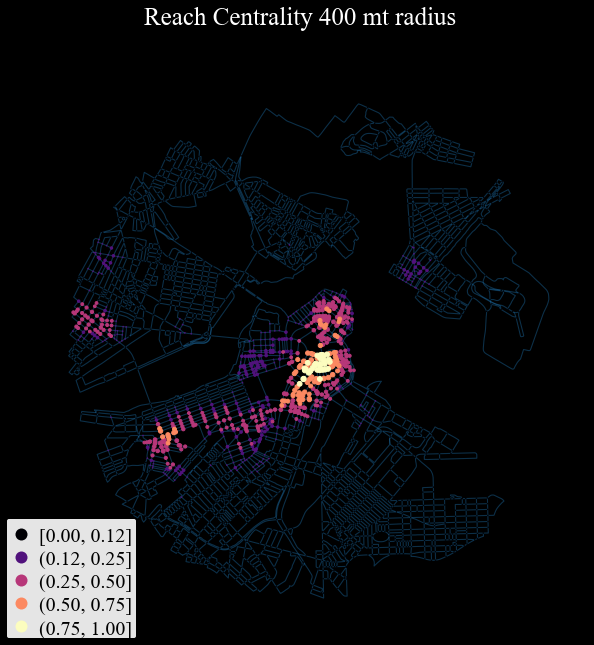

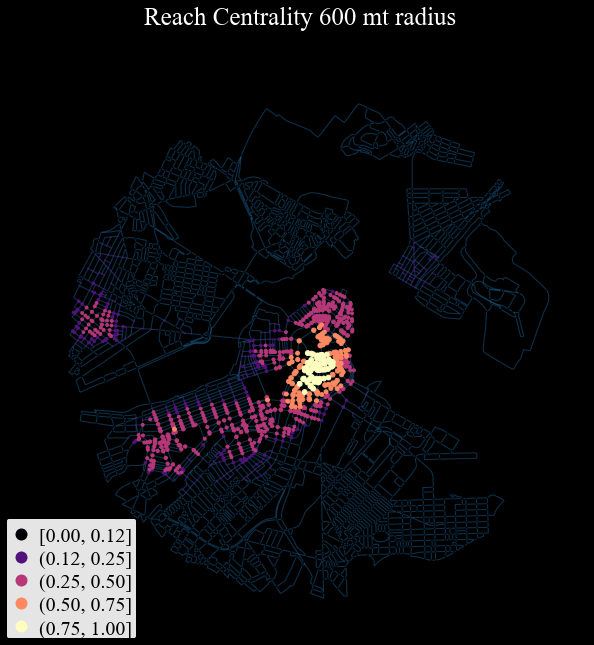

In [17]:
for n, column in enumerate(columns):
    ci.plot_gdf(nodes_graph, column = column, title = titles[n], cmap = 'magma', ms_factor = 30, fig_size = 10,
                   scheme ='Lynch_Breaks', gdf_base_map = edges_graph, base_map_zorder = 0, legend = True)

## 4. Paths

On the primal graph representation of the street network, the following centrality measures are computed on edges:
* Road Distance Betweenness centrality.
* Angular Betweenness centrality (On the dual graph representation of the street network)

In [18]:
# Road Distance betweenness centrality
Eb = nx.edge_betweenness_centrality(graph, weight = 'length', normalized = False)

In [27]:
# appending to the geodataframe
if 'Eb' in edges_graph.columns:
    edges_graph.drop(['Eb'], axis = 1, inplace = True)
edges_graph = ci.append_edges_metrics(edges_graph, graph, [Eb], ['Eb'])

## Dual graph analysis

Here street-segments are transformed into nodes (geograpically represented by their centroids). Fictional links represent instead intersections. Thus if two segments are connected in the actual street network, a link in the dual graph representation will be created by connecting the corresponding nodes. 
This process allows to take advantage of angular relationships in centrality measures computation and other network operations.

In [20]:
# Creating the dual geodataframes and the dual graph.
nodesDual_graph, edgesDual_graph = ci.dual_gdf(nodes_graph, edges_graph, epsg)
dual_graph = ci.dual_graph_fromGDF(nodesDual_graph, edgesDual_graph)

C:\Users\g_filo01\AppData\Local\Continuum\miniconda3\envs\cityImage\lib\site-packages\pyproj\crs.py:122: DeprecationWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  DeprecationWarning,


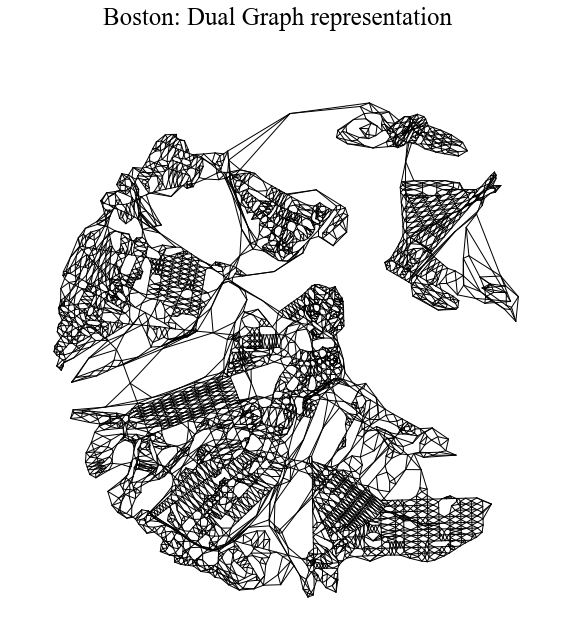

In [21]:
ci.plot_gdf(edgesDual_graph, black_background = False, fig_size = 10, title = city_name+': Dual Graph representation', 
         color = 'black')

### Angular Betweenness - Paths

In [23]:
# Angular-change betweenness centrality
Ab = nx.betweenness_centrality(dual_graph, weight = 'rad', normalized = False)
edges_graph['Ab'] = edges_graph.edgeID.map(Ab)

### 4.2 Paths (Edges' centrality) visualisation

C:\Users\g_filo01\AppData\Local\Continuum\miniconda3\envs\cityImage\lib\cityImage\plotting.py:633: MatplotlibDeprecationWarning: Saw kwargs ['size', 'fontsize'] which are all aliases for 'fontsize'.  Kept value from 'fontsize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  plt.setp(plt.getp(cax.axes, "yticklabels"), size = 0, color = text_color, fontfamily = 'Times New Roman', fontsize=font_size)


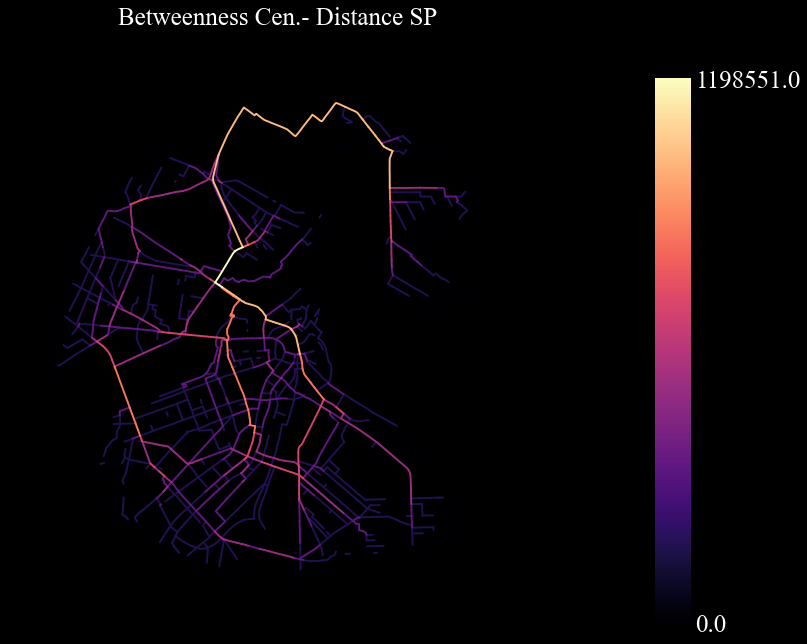

C:\Users\g_filo01\AppData\Local\Continuum\miniconda3\envs\cityImage\lib\cityImage\plotting.py:633: MatplotlibDeprecationWarning: Saw kwargs ['size', 'fontsize'] which are all aliases for 'fontsize'.  Kept value from 'fontsize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  plt.setp(plt.getp(cax.axes, "yticklabels"), size = 0, color = text_color, fontfamily = 'Times New Roman', fontsize=font_size)


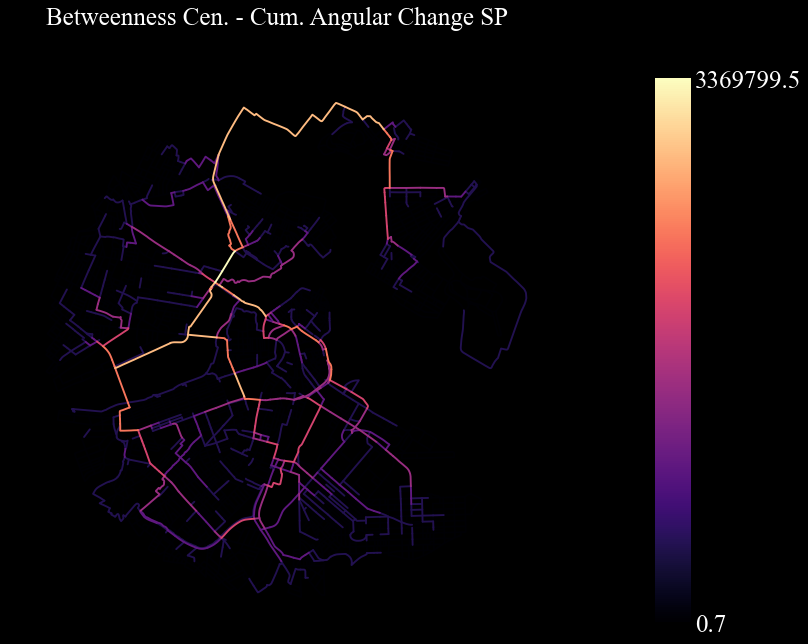

In [28]:
columns = ['Eb', 'Ab']
titles = ['Betweenness Cen.- Distance SP', 'Betweenness Cen. - Cum. Angular Change SP']

for n, column in enumerate(columns):
    ci.plot_gdf(edges_graph, classes = 8, column = column, title = titles[n], lw = 1.9, 
                  scheme = 'Natural_Breaks', cmap = 'magma', fig_size = 10, cbar = True, only_min_max = True)

## Exporting

In [29]:
# provide path
crs = {'init': 'epsg:'+str(epsg), 'no_defs': True}
saving_path = 'Outputs/'+city_name+'/'

# primal graph
nodes_graph.crs, edges_graph.crs = crs, crs
nodes_graph.to_file(saving_path+city_name+'_nodes.shp', driver='ESRI Shapefile')
edges_graph.to_file(saving_path+city_name+'_edges.shp', driver ='ESRI Shapefile')

# dual graph
nodesDual_graph.crs, edgesDual_graph.crs = crs, crs
nodesDual_graph.drop('intersecting', axis=1).to_file(saving_path+city_name+'_nodesDual.shp', driver = 'ESRI Shapefile')
edgesDual_graph.to_file(saving_path+city_name+'_edgesDual.shp', driver = 'ESRI Shapefile')

C:\Users\g_filo01\AppData\Local\Continuum\miniconda3\envs\cityImage\lib\site-packages\pyproj\crs.py:122: DeprecationWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  DeprecationWarning,
